In [21]:
# read video file and sample frames as input for source and target
from logger import setup_logger
from model import BiSeNet

import torch

import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

import random

def read_frames(video_file):
    frames = list()
    cap = cv2.VideoCapture(video_file)
    print(cap.get(cv2.CAP_PROP_FPS))
    ret, frame = cap.read()
    while ret:
        frames.append(frame)
        ret, frame = cap.read()
        
    return frames 


def read_frames_resize(video_file):
    frames = list()
    cap = cv2.VideoCapture(video_file)
    print(cap.get(cv2.CAP_PROP_FPS))
    ret, frame = cap.read()
    while ret:
        frames.append(frame[0:350, 250:600])
        ret, frame = cap.read()
        
    return frames


def random_sample(frames, to_sample=50):
    # start_index = random.randint(0, len(frames)-to_sample-1)
    start_index = 0
    print(f'Frames sampled from {start_index} to {start_index+to_sample}')
    return frames[start_index:start_index + to_sample]


def frames_to_video(frames, video_path, fps=30):
    height, width, layers = frames[0].shape
    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    for frame in frames:   
        video.write(frame) 
      
    cv2.destroyAllWindows() 
    video.release()
            
    print(f'Video {video_path} written successfully')
    

    # generate face crops using a fixed coordinates and for dimension 256x256 
def generate_face_crops(frames):
    resized_images = list()
    for frame in frames:
        # face_crop = frame[0:300,250:600]
        
        # resize the image to 256x256
        resize_img = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_CUBIC)
        resized_images.append(resize_img)

    return resized_images


transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

# CustomDataset 
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, frames, transform):
        self.transform = transform
        self.frames = frames

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, index):
        image = self.frames[index]
        resized = cv2.resize(image, (256, 256), interpolation = cv2.INTER_CUBIC)
        return self.transform(resized)
    
    
# the model was trained in the DataParallel mode, but inferencing using the cpu 

import sys
sys.path.insert(1, '/ssd_scratch/cvit/aditya1/vq-vae-2-pytorch/')
from vqvae import VQVAE
from collections import OrderedDict


# load the vqvae model and generate the predictions on the perturbed images
cp_path = '/ssd_scratch/cvit/aditya1/vq-vae-2-pytorch/checkpoint/vqvae_1000_30k.pt'
model = VQVAE()
state_dict = torch.load(cp_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model = model.to(device)
model.eval()

VQVAE(
  (enc_b): Encoder(
    (blocks): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResBlock(
        (conv): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (6): ResBlock(
        (conv): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (7): ReLU(inplace=True)
    )
  )
  (enc_t): Encoder(
    (blocks): Sequential(
      (0): Conv2d(128, 64,

In [2]:
n_classes = 19
net = BiSeNet(n_classes=n_classes).to(device='cuda')
cp_path = 'res/cp/79999_iter.pth'
net.load_state_dict(torch.load(cp_path))

net.eval()

to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

# takes an image as input and generates the segmentation
def generate_segmentation(img):
    net.eval()
    with torch.no_grad():
        image = cv2.resize(img, (512, 512), interpolation = cv2.INTER_LINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        device = torch.device('cuda')
        img = img.to(device)
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)

    return parsing, image

# This function segments the face using the face segmentation information
def generate_segmented_face(segmented_image, original_image):
    original_copy = np.asarray(original_image.copy())
    original_copy = np.transpose(original_copy, (2, 0, 1))

    # 3D mask needed for masking face (segmented background)
    field3d_face_mask = np.broadcast_to((segmented_image == 1) | (segmented_image == 2) | (segmented_image == 3) | 
                                        (segmented_image == 4) | (segmented_image == 5) | (segmented_image == 6) |
                                        (segmented_image == 7) | (segmented_image == 8) | (segmented_image == 9) | 
                                        (segmented_image == 10) | (segmented_image == 11) | (segmented_image == 12) | 
                                        (segmented_image == 13)
                                        , original_copy.shape) 

    # 3D mask needed for masking background (segmenting face)
    field3d_background_mask = np.broadcast_to((segmented_image == 0) | (segmented_image > 13), original_copy.shape)

    background_image = original_copy.copy()
    face_image = original_copy.copy()

    background_image[field3d_face_mask] = 0
    face_image[field3d_background_mask] = 0

    background_image = np.transpose(background_image, (1, 2, 0))
    face_image = np.transpose(face_image, (1, 2, 0))
    
    return face_image, background_image


# Method to combine the face segmented with the face segmentation mask
def combine_images(face_mask, face_image, generate_mask=True):
    image_masked = face_mask.copy()
    if generate_mask:
        mask = face_image[..., 0] != 0
        image_masked[mask] = 0
    
    combined_image = image_masked + face_image
    
    return combined_image


# generate face crop from the image and resize
def generate_face_crop(image):
    face_crop = image[0:350, 120:350]
    resize_img = cv2.resize(face_crop, (256, 256), interpolation=cv2.INTER_CUBIC)
    return resize_img
    

def generate_face_segmentation(frames, require_face=True):
    segmented = list()
    for frame in frames:
        parsing, image = generate_segmentation(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        face_image, background_image = generate_segmented_face(parsing, image)
        segmented.append(face_image if require_face else background_image)
        
    return segmented

def generate_combined_images(face_masked, face_images):
    combined_images = list()
    for i in range(len(face_masked)):
        combined_image = combine_images(face_masked[i], face_images[i])
        combined_images.append(combined_image)
        
    return combined_images


# generate face crops from the images
def generate_face_crops(images):
    face_crops = list()
    for image in images:
        face_crop = generate_face_crop(image)
        face_crops.append(face_crop)
        
    return face_crops


def frames_to_video_tensor(frames_tensor, video_file):
    
    height, width, layers = frames_tensor[0].shape
    video = cv2.VideoWriter(video_file, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    
    #size = (frames_tensor[0].shape[0], frames_tensor[0].shape[1])
    #out = cv2.VideoWriter(video_file, cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

    for frame_tensor in frames_tensor:
        if isinstance(frame_tensor, torch.Tensor):
            frame_np = np.asarray(frame_tensor.detach().cpu())
        else:
            frame_np = frame_tensor
#         video.write(cv2.cvtColor((frame_np*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
        video.write(cv2.cvtColor(frame_np, cv2.COLOR_BGR2RGB))
        
    cv2.destroyAllWindows()
    video.release()
    

def predictions_tensor_to_video(predictions, video_file):
    channels, height, width = predictions[0].shape
    video = cv2.VideoWriter(video_file, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    
    for prediction in predictions:
        prediction = (prediction + 1)/2
        prediction = prediction.permute(1, 2, 0)
        prediction_np = np.asarray(prediction.detach().cpu())
        video.write(cv2.cvtColor((prediction_np*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
                
    cv2.destroyAllWindows()
    video.release()
    
    
def visualize_tensor_image(image_tensor):
    image_tensor = (image_tensor+1)/2
    image_tensor = image_tensor.permute(1, 2, 0)
    plt.figure()
    plt.imshow(image_tensor.detach().cpu())

In [25]:
# Code for generating the source and the target frames
video_file_source = 'sample_files/mead/001.mp4'
video_file_target = 'sample_files/mead/005.mp4'
# frames1 = read_frames(video_file)
# frames = read_frames_resize(video_file)

source_frames = read_frames(video_file_source)
target_frames = read_frames(video_file_target)

source_frames = random_sample(source_frames, to_sample=80)
print(len(source_frames))
target_frames = random_sample(target_frames, to_sample=80)
print(len(target_frames))

# source_frames_resized = generate_face_crops(source_frames)
# target_frames_resized = generate_face_crops(target_frames)

30.000457875457876
30.000457875457876
Frames sampled from 0 to 80
80
Frames sampled from 0 to 80
80


Video source_frames_original.mp4 written successfully
Video target_frames_original.mp4 written successfully


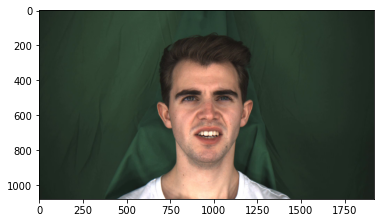

In [36]:
frames_to_video(source_frames, 'source_frames_original.mp4')
frames_to_video(target_frames, 'target_frames_original.mp4')

img_sample = cv2.cvtColor(frames1[0], cv2.COLOR_BGR2RGB)
face_cropped = img_sample[100:1000, 600:1250]

plt.figure()
plt.imshow(img_sample)

def generate_crop(frames_input):
    # face_cropped = img_sample[0:350, 250:600]
    frames_resized = list()
    for face in frames_input:
        face_cropped = cv2.resize(face[150:950, 500:1300], (512, 512), interpolation=cv2.INTER_CUBIC)
        # face_cropped = cv2.cvtColor(face_cropped, cv2.COLOR_BGR2RGB)
        # plt.figure()
        # plt.imshow(face_cropped)
        frames_resized.append(face_cropped)

    return frames_resized

source_frames_resized = generate_crop(source_frames)
target_frames_resized = generate_crop(target_frames)

    
# plt.figure()
# plt.imshow(face_cropped)

# face_resized = cv2.resize(face_cropped, (512, 512), interpolation=cv2.INTER_CUBIC)
# plt.figure()
# plt.imshow(face_resized)

In [37]:
face_segments = generate_face_segmentation(source_frames_resized, require_face=True)
face_masked = generate_face_segmentation(target_frames_resized, require_face=False)

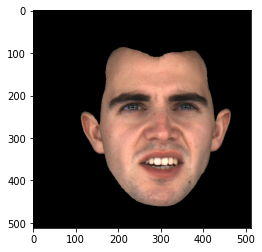

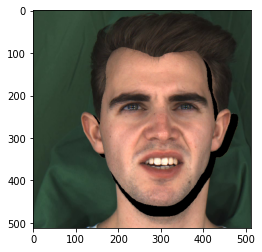

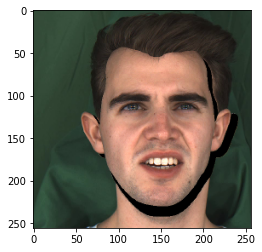

In [38]:
face_sample = face_segments[0]
plt.figure()
plt.imshow(face_sample)

combined_images = generate_combined_images(face_masked, face_segments)
combined_image = combined_images[0]
plt.figure()
plt.imshow(combined_image)

# face_crop = combined_image[0:350, 120:350]
# plt.figure()
# plt.imshow(face_crop)

frames_to_video_tensor(combined_images, 'combined_images.mp4')

face_crops = generate_face_crops(combined_images)
plt.figure()
plt.imshow(face_crops[0])

frames_to_video_tensor(face_crops, 'face_crops_combined.mp4')

In [39]:
dataset = CustomDataset(face_crops, transform)
loader = DataLoader(dataset, shuffle=True, batch_size=16, num_workers=1)

In [40]:
generated_images = list()
for i, batch in enumerate(loader):
    batch = batch.to(device)
    predictions, _ = model(batch)
    for prediction in predictions:
        generated_images.append(prediction)
        
# save the generated images in the disk as video
predictions_tensor_to_video(generated_images, 'predictions_video.mp4')

torch.Size([16, 3, 256, 256])


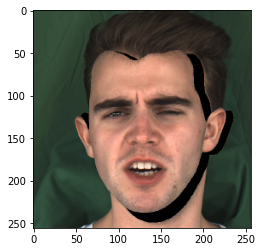

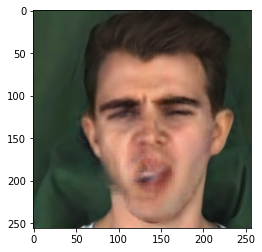

In [41]:
batch = next(iter(loader))
batch = batch.to(device)
predictions, _ = model(batch)
sample = batch[0]
visualize_tensor_image(sample)
print(predictions.shape)
visualize_tensor_image(predictions[0].squeeze(0))

# predictions_tensor_to_video(predictions, 'predictions_video.mp4')

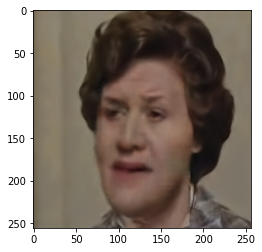

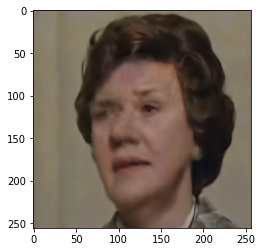

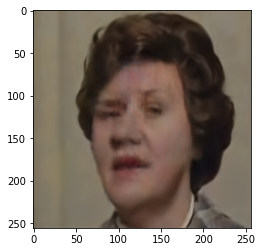

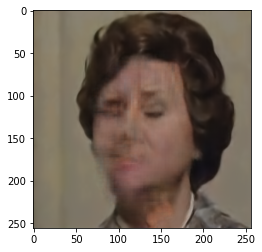

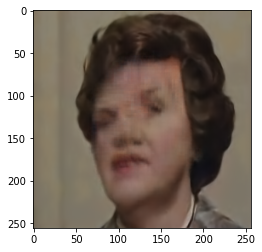

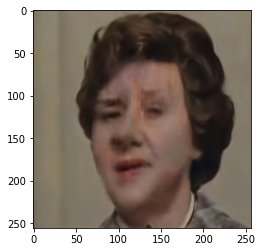

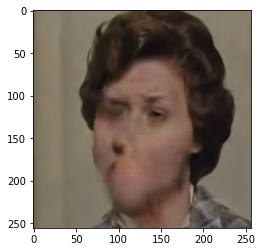

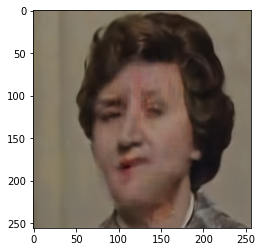

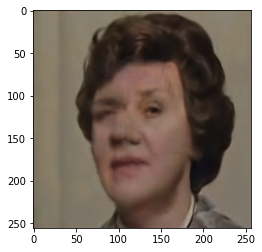

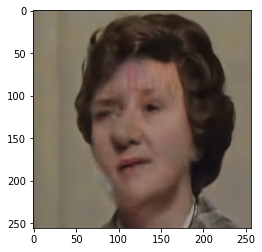

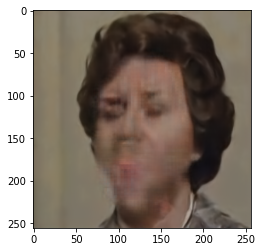

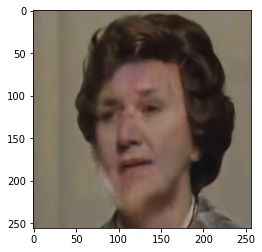

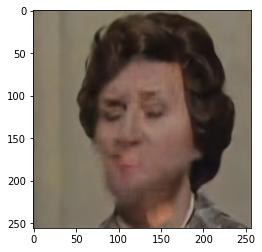

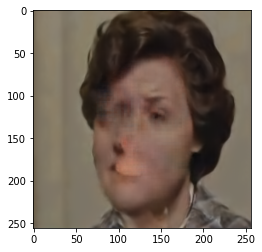

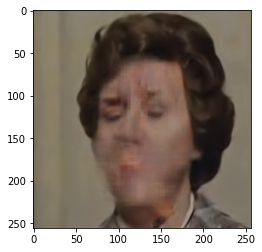

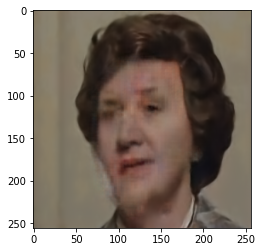

In [41]:
batch = next(iter(loader))
batch = batch.to(device)
predictions, _ = model(batch)
for prediction in predictions:
    visualize_tensor_image(prediction)